In [1]:
import numpy as np
import requests
from mip import Model, MAXIMIZE, BINARY, xsum
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import polyline


In [2]:
sources = [
    {'name': 'Phoenix, AZ', 'lat': 33.4484, 'lon': -112.0740},
    {'name': 'Los Angeles, CA', 'lat': 34.0522, 'lon': -118.2437},
    {'name': 'Portland, OR', 'lat': 45.5155, 'lon': -122.6793},
    {'name': 'Seattle, WA', 'lat': 47.6062, 'lon': -122.3321}
]

np.random.seed(42)
lat_min, lat_max = 32.0, 49.0
lon_min, lon_max = -125.0, -115.0
dest_lats = np.random.uniform(lat_min, lat_max, 30)
dest_lons = np.random.uniform(lon_min, lon_max, 30)
# destinations = [{'lat': lat, 'lon': lon, 'score': np.random.randint(1, 10)} 
destinations = [{'lat': lat, 'lon': lon, 'score': 1} 
                for lat, lon in zip(dest_lats, dest_lons)]

nodes = sources + destinations
n_nodes = len(nodes)
n_sources = len(sources)


In [3]:
def get_osrm_distance_matrix(coords):
    coord_str = ";".join([f"{c['lon']},{c['lat']}" for c in coords])
    url = f"http://router.project-osrm.org/table/v1/driving/{coord_str}?annotations=distance"
    
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"OSRM API Error: {response.text}")
    
    data = response.json()
    return np.array(data['distances'])

# Get OSRM distance matrix (in meters)
coords = [{'lon': node['lon'], 'lat': node['lat']} for node in nodes]
distance_matrix = get_osrm_distance_matrix(coords)  # Shape: (n_nodes x n_nodes)

# Convert meters to kilometers for modeling
distance = (distance_matrix / 1000).tolist()

In [ ]:
T_max = 10_000  # Max route distance in kilometers
model = Model('TOP with Road Distances', sense=MAXIMIZE)

# Variables
y = [[model.add_var(var_type=BINARY, name=f'y_{k}_{i}') 
      for i in range(n_nodes)] for k in range(n_sources)]
x = [[[model.add_var(var_type=BINARY, name=f'x_{k}_{i}_{j}') 
       for j in range(n_nodes)] for i in range(n_nodes)] 
      for k in range(n_sources)]

# Objective: Maximize total score
model.objective = xsum(destinations[i - n_sources]['score'] * y[k][i] 
                  for k in range(n_sources) for i in range(n_sources, n_nodes))

for i in range(n_sources, n_nodes):
    model += xsum(y[k][i] for k in range(n_sources)) <= 1  # Visit once

for k in range(n_sources):
    sk = k  # Source node for vehicle k
    model += y[k][sk] == 1  # Start/end at source

    for i in range(n_nodes):
        if i != sk:
            model += y[k][i] == xsum(x[k][j][i] for j in range(n_nodes) if j != i)
            model += y[k][i] == xsum(x[k][i][j] for j in range(n_nodes) if j != i)
            model += xsum(x[k][j][i] for j in range(n_nodes) if j != i) == \
                     xsum(x[k][i][j] for j in range(n_nodes) if j != i)

    model += xsum(x[k][sk][j] for j in range(n_nodes) if j != sk) == 1
    model += xsum(x[k][j][sk] for j in range(n_nodes) if j != sk) == 1
    model += xsum(x[k][i][j] * distance[i][j] for i in range(n_nodes) 
              for j in range(n_nodes) if i != j) <= T_max


In [5]:
model.optimize(max_seconds=20*60)

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 438 (-4) rows, 4620 (-140) columns and 22560 (-4) elements
Clp1000I sum of infeasibilities 6.56795e-06 - average 1.49953e-08, 4 fixed columns
Coin0506I Presolve 438 (0) rows, 4616 (-4) columns and 22540 (-20) elements
Clp0029I End of values pass after 4616 iterations
Clp0000I Optimal - objective value 30
Clp0000I Optimal - objective value 30
Coin0511I After Postsolve, objective 30, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 30
Clp0000I Optimal - objective value 30
Clp0000I Optimal - objective value 30
Coin0511I After Postsolve, objective 30, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 30 - 0 iterations time 0.302, Presolve 0.01, Idiot 0.30

Starting MIP optimization
Cgl0004I processed model has 186 rows, 4500 columns (4500 integer (4500 of which binary

<OptimizationStatus.OPTIMAL: 0>

In [6]:
def get_route_geometry(start_lon, start_lat, end_lon, end_lat):
    url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=full"
    response = requests.get(url)
    if response.status_code != 200:
        return None
    data = response.json()
    if data['code'] != 'Ok':
        return None
    return polyline.decode(data['routes'][0]['geometry'])

routes_geo = []
for k in range(n_sources):
    route = []
    current = k
    while True:
        next_nodes = [j for j in range(n_nodes) 
                      if j != current and x[k][current][j].x >= 0.99]
        if not next_nodes:
            break
        next_node = next_nodes[0]
        route.append((current, next_node))
        current = next_node
        if current == k:
            break
    
    # Get road geometry for each segment
    geo_path = []
    for (i, j) in route:
        coords_i = (nodes[i]['lon'], nodes[i]['lat'])
        coords_j = (nodes[j]['lon'], nodes[j]['lat'])
        segment = get_route_geometry(*coords_i, *coords_j)
        if segment:
            geo_path.extend(segment)
    routes_geo.append(geo_path)


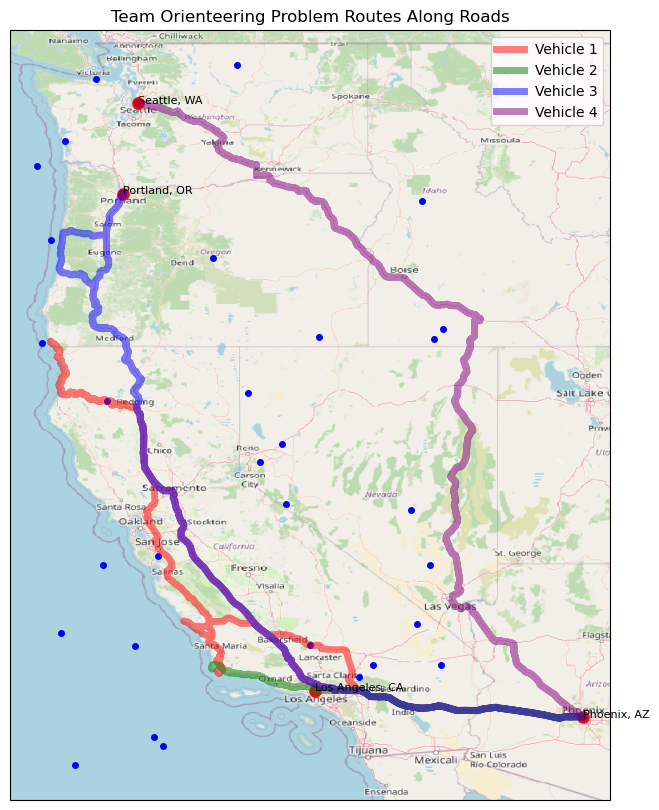

In [7]:

plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
osm_tiles = cimgt.OSM()
ax.add_image(osm_tiles, 6)

# Plot sources
for i in range(n_sources):
    ax.plot(nodes[i]['lon'], nodes[i]['lat'], 'ro', markersize=8, 
            transform=ccrs.Geodetic())
    ax.text(nodes[i]['lon'], nodes[i]['lat'], sources[i]['name'], 
            transform=ccrs.Geodetic(), fontsize=8, color='black')

# Plot destinations
for i in range(n_sources, n_nodes):
    ax.plot(nodes[i]['lon'], nodes[i]['lat'], 'bo', markersize=4, 
            transform=ccrs.Geodetic())

# Plot road routes
colors = ['red', 'green', 'blue', 'purple']
for k, path in enumerate(routes_geo):
    if not path:
        continue
    lats, lons = zip(*path)
    ax.plot(lons, lats, color=colors[k], linewidth=5, 
            transform=ccrs.Geodetic(), label=f'Vehicle {k+1}', alpha=0.5)

plt.legend()
plt.title('Team Orienteering Problem Routes Along Roads')
plt.show()